# Create Nightly Epoch Lightcurves

Create nightly-epoch lightcurves for "good" candidates, to use as a starting sample for transient science with the DECam deep drilling field data.

"Good" means at least 10 objects (detections in any filter) and a mean real-bogus score > 0.4 for all objects.

Create output files in the same format as made by `candidate_nightly_epochs.ipynb`:
 * candidate_lightcurves.dat
 * candidate_lightcurve_parameters.dat
 

## 0. Set up

Import packages and connect to database.

In [33]:
import psycopg2
import psycopg2.extras
import getpass
import pandas

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.time import Time

from copy import deepcopy
import time

User decat_ro, in order to access `versiontags`.

In [3]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

DB User:  decat_ro
DB Password:  ········


In [4]:
db.autocommit = True
cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

If you want to print table schema.

In [ ]:
# tables = ['versiontags','exposures','subtractions','images',\
#           'objects','objectrbs','objectdatas','objectdata_versiontag','candidates']
# for table in tables:
#     query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name=%s"
#     cursor.execute( query, ( table, ))
#     print( f"\nTABLE: {table}\n===========================" )
#     for row in cursor:
#         print( f"{row['column_name']:24s}  :  {row['data_type']:s}" )

Things in the database are tagged with versions.
This is because we might redo something, or we might try different subtraction algorithms.
This might change in the future, but, at the moment everything that's in the database should be tagged with the "latest" tag, which means it was the last thing saved to the database.

In [5]:
tag = "latest"
db.rollback()
q = ( "SELECT id, tag FROM versiontags WHERE tag=%(tag)s" )
cursor.execute( q, { "tag": tag } )
row = cursor.fetchone()
tagid = row['id']
print(tagid)

1


## 1. Query

Get all the objects in ELAIS and COSMOS fields.

This takes about a minute.

In [6]:
%%time
q = ("SELECT od.ra, od.dec, od.mag, od.magerr, rbs.rb, "
     "i.filter, i.meanmjd, o.candidate_id, e.proposalid "
     "FROM objectdatas AS od "
     "INNER JOIN objectdata_versiontag AS odvt "
     "ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
     "INNER JOIN objects AS o ON od.object_id=o.id "
     "INNER JOIN images AS i ON o.image_id=i.id "
     "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
     "INNER JOIN exposures AS e ON i.exposure_id=e.id "
     "WHERE ((od.ra > 147.0 AND od.ra < 153.0 AND od.dec > -0.25 AND od.dec < 5) "
     "OR (od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41)) ")
cursor.execute(q, {'tagid': tagid})
df = pandas.DataFrame(cursor.fetchall())

CPU times: user 33.9 s, sys: 4.45 s, total: 38.3 s
Wall time: 50.9 s


Print total number of objects.

In [7]:
print(len(df))

3828261


Put the objects into numpy arrays.

In [8]:
raw_obj_ra     = np.asarray(df[0], dtype='float')
raw_obj_dec    = np.asarray(df[1], dtype='float')
raw_obj_mag    = np.asarray(df[2], dtype='float')
raw_obj_mage   = np.asarray(df[3], dtype='float')
raw_obj_rb     = np.asarray(df[4], dtype='float')
raw_obj_filt   = np.asarray(df[5], dtype='str')
raw_obj_mjd    = np.asarray(df[6], dtype='float')
raw_obj_candid = np.asarray(df[7], dtype='str')
raw_obj_propid = np.asarray(df[8], dtype='str')
del df

## 2. Identify good candidates only

The unique candidates for these objects.

In [9]:
values, indices, inverse, counts = np.unique(raw_obj_candid, return_index=True, return_inverse=True,  return_counts=True)

In [10]:
print('len(values), len(indices), len(inverse), len(counts)', len(values), len(indices), len(inverse), len(counts))
print(' ')
print('On average, %4.2f objects per candidate' % (len(raw_obj_candid)/len(values)))

len(values), len(indices), len(inverse), len(counts) 1367538 1367538 3828261 1367538
 
On average, 2.80 objects per candidate


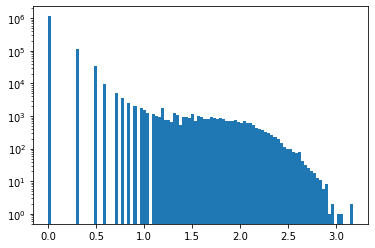

In [11]:
hist = plt.hist(np.log10(counts), bins=100, log=True)
plt.show()

In [12]:
print(hist[0][0])

1155445.0


In [13]:
dx = np.where(counts[inverse] == 1)[0]
print(len(dx))

1155445


<br> 

Delete all objects of candidates with less than 10 objects.

Making the object arrays smaller speeds up the processing later on.

In [14]:
dx = np.where(counts[inverse] < 10)[0]
print(len(dx))

1629413


In [15]:
obj_ra     = np.delete(raw_obj_ra, dx)
obj_dec    = np.delete(raw_obj_dec, dx)
obj_mag    = np.delete(raw_obj_mag, dx)
obj_mage   = np.delete(raw_obj_mage, dx)
obj_rb     = np.delete(raw_obj_rb, dx)
obj_filt   = np.delete(raw_obj_filt, dx)
obj_mjd    = np.delete(raw_obj_mjd, dx)
obj_candid = np.delete(raw_obj_candid, dx)
obj_propid = np.delete(raw_obj_propid, dx)
del dx
del values, indices, counts

In [19]:
values, indices, inverse, counts = np.unique(obj_candid, return_index=True, return_inverse=True, return_counts=True)

In [20]:
print('len(values), len(indices), len(inverse), len(counts)', len(values), len(indices), len(inverse), len(counts))
print(' ')
print('On average, %4.2f objects per candidate' % (len(obj_candid)/len(values)))

len(values), len(indices), len(inverse), len(counts) 35317 35317 2198848 35317
 
On average, 62.26 objects per candidate


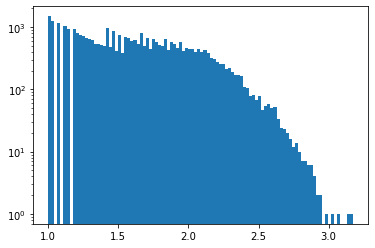

In [21]:
plt.hist(np.log10(counts), bins=100, log=True)
plt.show()

Calculate the mean real-bogus for all remaining candidates.

In [24]:
cand_id = values
cand_nob = counts
cand_mrb = np.zeros(len(cand_id), dtype='float')

In [25]:
%%time
t0 = time.time()
for c, cid in enumerate(cand_id):
    if (c == 100) | (c == 1000) | (c == 10000):
        t1 = time.time()
        print(c, t1 - t0, 'sec')
    cx = np.where(obj_candid == cid)[0]
    cand_nob[c] = len(cx)
    cand_mrb[c] = np.nanmean(obj_rb[cx])
    del cx

100 1.560276746749878 sec
1000 13.634588241577148 sec
10000 121.94928550720215 sec
CPU times: user 6min 42s, sys: 145 ms, total: 6min 42s
Wall time: 6min 42s


In [26]:
dx = np.where(cand_mrb < 0.4)[0]
print(len(dx))

29967


In [27]:
cand_ids = np.delete(cand_id, dx)
cand_nobjs = np.delete(cand_nob, dx)
cand_meanrb = np.delete(cand_mrb, dx)

In [28]:
print(len(cand_ids))

5350


## 3. Make the lightcurve files for good objects

In [34]:
times = ['2021-02-01T00:00:00',
         '2021-08-01T00:00:00',
         '2022-02-01T00:00:00',
         '2022-08-01T00:00:00',
         '2023-02-01T00:00:00']
t = Time(times, format='isot', scale='utc')

In [36]:
t.mjd

array([59246., 59427., 59611., 59792., 59976.])

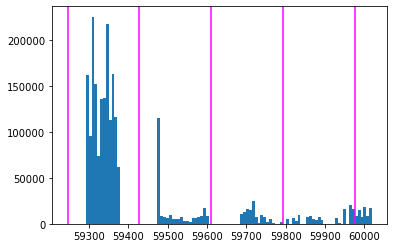

In [38]:
plt.hist(obj_mjd, bins=100)
for mjd in t.mjd:
    plt.axvline(mjd, color='magenta')
plt.show()

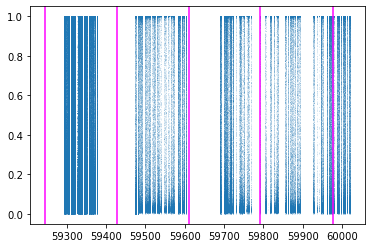

In [39]:
plt.plot(obj_mjd, obj_rb, 'o', ms=1, alpha=0.1, mew=0)
for mjd in t.mjd:
    plt.axvline(mjd, color='magenta')